# Homework: Implement a Mixture of Experts Model

## Overview

In this homework, you'll implement a Mixture of Experts (MoE) model for classifying points generated from two Gaussian distributions.

Please submit your Jupyter Notebook with all the completed tasks and questions answered.

In [1]:
# Import Libraries

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Generate the Dataset
def generate_data(n_samples=2000):
  X = torch.zeros(n_samples, 2)
  y = torch.zeros(n_samples, dtype=torch.long)

  # Generate samples from two Gaussian distributions
  X[:n_samples//2] = torch.randn(n_samples//2, 2) + torch.Tensor([3,2])
  X[n_samples//2:] = torch.randn(n_samples//2, 2) + torch.Tensor([-3,2])

  # Labels
  for i in range(X.shape[0]):
    if X[i].norm() > math.sqrt(13):
      y[i] = 1

  X[:, 1] = X[:, 1] - 2

  return X, y

data, labels = generate_data()

Question: Plot the generated dataset. Do you think a linear model would be able to separate the classes well?

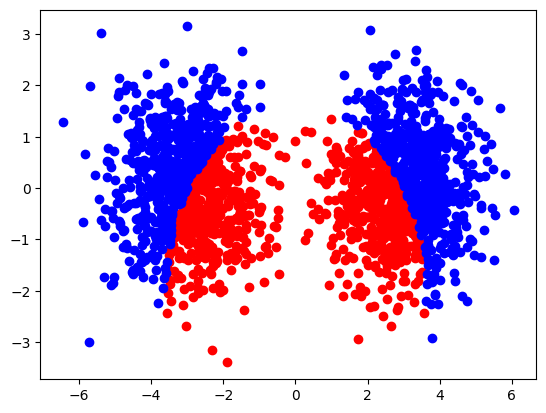

In [4]:
# Visualize the data
# TODO
import numpy as np

zeros, ones = [], []
for d, label in zip(data, labels):
  if label == 0:
    zeros.append(d)
  else:
    ones.append(d)
    
zeros = np.array(zeros)
ones = np.array(ones)

x0, y0 = zeros.T
x1, y1 = ones.T

plt.scatter(x0, y0, c="red")
plt.scatter(x1, y1, c="blue")

## Expert Model

Task: Implement the Expert model. It should be a simple neural network with one linear layer.



In [5]:
class Expert(nn.Module):
  # TODO
  def __init__(self):
    super().__init__()
    self.layer1 = torch.nn.Linear(in_features=2, out_features=1)
    
  def forward(self, x):
    return self.layer1(x)

## Gating Network

Task: Implement the Gating Network. It should output the probabilities for choosing each expert.

In [6]:
class GatingNetwork(nn.Module):
  def __init__(self, num_experts):
      super().__init__()
      self.layer1 = torch.nn.Linear(in_features=2, out_features=num_experts)

  def forward(self, x):
      out = self.layer1(x)
      out = torch.softmax(x, dim=1)
      return out


## Mixture of Experts

Task: Implement the Mixture of Experts model. This model should utilize the Expert and Gating Network models to make a final prediction.

In [13]:
class MixtureOfExperts(nn.Module):
  # TODO
  def __init__(self, num_experts=2):
    super().__init__()
    self.num_experts = num_experts
    self.experts = nn.ModuleList([Expert() for _ in range(num_experts)])
    self.gating_net = GatingNetwork(num_experts=num_experts)
    
  
  def forward(self, x):
    gated = self.gating_net(x)
    expert_outs = [expert(x) for expert in self.experts]
    expert_outs = torch.stack(expert_outs, dim=2)

    # combining weights of the expert outputs
    gated_outs = expert_outs @ gated.unsqueeze(2)
    return gated_outs.squeeze(2)


## Training Loop

Task: Write a training loop to train the Mixture of Experts model. Use binary cross-entropy loss and an Adam optimizer. Also, implement a learning rate scheduler that decays the learning rate.

In [47]:
from tqdm import tqdm

# Define the model, loss, and optimizer
model = MixtureOfExperts(2) 
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 12

# Define the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer=optimizer, start_factor=1.0, end_factor=0.1, 
    total_iters=num_epochs) 

# Convert data and labels to float tensors
data_tensor = data.float()
labels_tensor = labels.view(-1, 1).float()

# Training loop
progress = tqdm(range(num_epochs))
for epoch in progress:
    # Forward pass
    # TODO
    model.train()
    outputs = model(data_tensor)
    
    loss = criterion(outputs, labels_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    
    progress.set_postfix({"loss": loss.item()})

# accuracy
test_data, test_labels = generate_data(n_samples=500)
test_data = test_data.float()
test_labels = test_labels.view(-1, 1).float()
test_result = model(test_data)
test_result = (test_result > 0.5).float()

acc = len([i for i in range(500)
           if abs(test_labels[i] - test_result[i]) < 1e-17])
print("accuracy: ", acc * 1.0/500.0)

100%|██████████| 12/12 [00:00<00:00, 600.87it/s, loss=-0]

accuracy:  0.734


## Decision Boundaries
Task: Plot the decision boundaries of the two experts, the gating network and the final model

In [ ]:
# TODO


Question: Analyze the decision boundaries. What differences do you observe between the experts? How does the gating network decide between the two?

## Bonus Task (2 points)
Try increasing the number of experts. How does the model complexity and decision boundary change? (You don't need to show your code for the new models, just plot the new decision boundaries and explain what did you find from the plots)

